In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

# 3-label Roberta Finetune

In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import json
from datasets import load_dataset, DatasetDict, Dataset

from transformers import RobertaTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = './data'

def load_data_file(path):
    lines_list = []
    with open(path, 'r') as f:
        for line in f:
            lines_list.append(json.loads(line))

    df = pd.DataFrame(lines_list)
    
    return df

def preprocess(df):
    # Combine context and target
    contexts = df['context'].values
    targets = df['target'].values
    df['text'] = list(map(lambda x,y: str(x) + ' [SEP] ' + str(y), contexts, targets))
    df = df.drop(columns=['context', 'target'])
    
    # Cast label to int
    df['label'] = list(map(lambda x: int(x), df['label']))
    
    # TODO: Binarize labels
    
    return df

train_gold_df = load_data_file(data_path + '/gold/train.jsonl')
val_gold_df = load_data_file(data_path + '/gold/val.jsonl')
test_df = load_data_file(data_path + '/gold/test.jsonl') # The test set only comes from the 'gold' category

train_silver_df = load_data_file(data_path + '/silver/train.jsonl')
val_silver_df = load_data_file(data_path + '/silver/val.jsonl')

#Combine Gold and Silver
train_df = pd.concat([train_gold_df, train_silver_df])
val_df = pd.concat([val_gold_df, val_silver_df])

train_df = preprocess(train_df)
val_df = preprocess(val_df)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, add_special_tokens = True)

train_encoded = train_ds.map(tokenize, batched=True, batch_size=None)
val_encoded = train_ds.map(tokenize, batched=True, batch_size=None)



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}



model_ckpt = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", 
                                                           num_labels=3)

batch_size = 4
logging_steps = len(train_encoded) // batch_size
print(logging_steps)
model_name = model_ckpt + "-finetune"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  save_total_limit = 2)

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded,
                  eval_dataset=val_encoded,
                  tokenizer=tokenizer)
trainer.train()
trainer.save_model("model")

In [4]:
logs = [
    {
        'loss': 1.0504,
        'learning_rate': 1.7500000000000002e-05,
        'eval_loss': 1.029897928237915,
        'eval_accuracy': 0.5088,
        'eval_f1': 0.3736653454006238,
        'eval_runtime': 46.972,
        'eval_samples_per_second': 106.446,
        'eval_steps_per_second': 26.612,
        'epoch': 1.0
    },
    {
        'loss': 0.9781,
        'learning_rate': 1.5000000000000002e-05,
        'eval_loss': 0.840813398361206,
        'eval_accuracy': 0.6424,
        'eval_f1': 0.56688350507592,
        'eval_runtime': 46.818,
        'eval_samples_per_second': 106.797,
        'eval_steps_per_second': 26.699,
        'epoch': 2.0
    },
    {
        'loss': 0.8566,
        'learning_rate': 1.25e-05,
        'eval_loss': 0.7092211246490479,
        'eval_accuracy': 0.7366,
        'eval_f1': 0.7193137582035783,
        'eval_runtime': 46.8272,
        'eval_samples_per_second': 106.775,
        'eval_steps_per_second': 26.694,
        'epoch': 3.0
    },
    {
        'loss': 0.7543,
        'learning_rate': 1e-05,
        'eval_loss': 0.5204271078109741,
        'eval_accuracy': 0.8188,
        'eval_f1': 0.8181573594078856,
        'eval_runtime': 46.732,
        'eval_samples_per_second': 106.993,
        'eval_steps_per_second': 26.748,
        'epoch': 4.0
    },
    {
        'loss': 0.6637,
        'learning_rate': 7.500000000000001e-06,
        'eval_loss': 0.3766619861125946,
        'eval_accuracy': 0.8884,
        'eval_f1': 0.8886097251146162,
        'eval_runtime': 46.7722,
        'eval_samples_per_second': 106.901,
        'eval_steps_per_second': 26.725,
        'epoch': 5.0
    },
    {
        'loss': 0.5568,
        'learning_rate': 5e-06,
        'eval_loss': 0.3678179979324341,
        'eval_accuracy': 0.917,
        'eval_f1': 0.9170797350619568,
        'eval_runtime': 46.7381,
        'eval_samples_per_second': 106.979,
        'eval_steps_per_second': 26.745,
        'epoch': 6.0
    },
    {
        'loss': 0.466,
        'learning_rate': 2.5e-06,
        'eval_loss': 0.2727004289627075,
        'eval_accuracy': 0.9402,
        'eval_f1': 0.9402160976443098,
        'eval_runtime': 46.7837,
        'eval_samples_per_second': 106.875,
        'eval_steps_per_second': 26.719,
        'epoch': 7.0
    },
    {
        'loss': 0.3847,
        'learning_rate': 0.0,
        'eval_loss': 0.26842257380485535,
        'eval_accuracy': 0.9464,
        'eval_f1': 0.9462601781741261,
        'eval_runtime': 46.7111,
        'eval_samples_per_second': 107.041,
        'eval_steps_per_second': 26.76,
        'epoch': 8.0
    }
]

In [21]:
list(logs[0].keys())
for l in logs:
    for key in list(l.keys()):
        print(l[key])

1.0504
1.7500000000000002e-05
1.029897928237915
0.5088
0.3736653454006238
46.972
106.446
26.612
1.0
0.9781
1.5000000000000002e-05
0.840813398361206
0.6424
0.56688350507592
46.818
106.797
26.699
2.0
0.8566
1.25e-05
0.7092211246490479
0.7366
0.7193137582035783
46.8272
106.775
26.694
3.0
0.7543
1e-05
0.5204271078109741
0.8188
0.8181573594078856
46.732
106.993
26.748
4.0
0.6637
7.500000000000001e-06
0.3766619861125946
0.8884
0.8886097251146162
46.7722
106.901
26.725
5.0
0.5568
5e-06
0.3678179979324341
0.917
0.9170797350619568
46.7381
106.979
26.745
6.0
0.466
2.5e-06
0.2727004289627075
0.9402
0.9402160976443098
46.7837
106.875
26.719
7.0
0.3847
0.0
0.26842257380485535
0.9464
0.9462601781741261
46.7111
107.041
26.76
8.0


In [26]:
result = {}

for k in list(logs[0].keys()):
    result[k] = []

for l in logs:
    for k in list(l.keys()):
        result[k].append(l[k])
        
result['eval_accuracy']

[0.5088, 0.6424, 0.7366, 0.8188, 0.8884, 0.917, 0.9402, 0.9464]

Text(0.5, 1.0, 'Accuracy per Epoch')

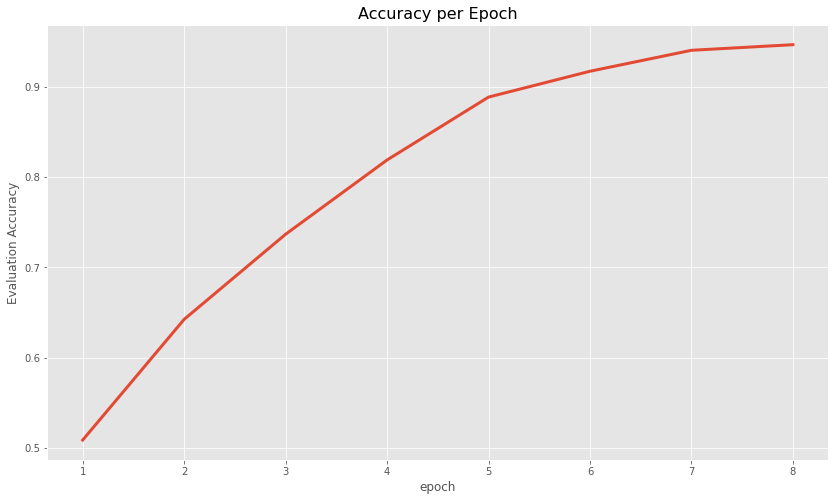

In [29]:
plt.figure(figsize=(14,8))
plt.plot(result['epoch'], result['eval_accuracy'], linewidth=3)
    
# plt.legend(title="LR")   
plt.xlabel("epoch")
plt.ylabel("Evaluation Accuracy")
plt.title("Accuracy per Epoch")

Text(0.5, 1.0, 'F1 per Epoch')

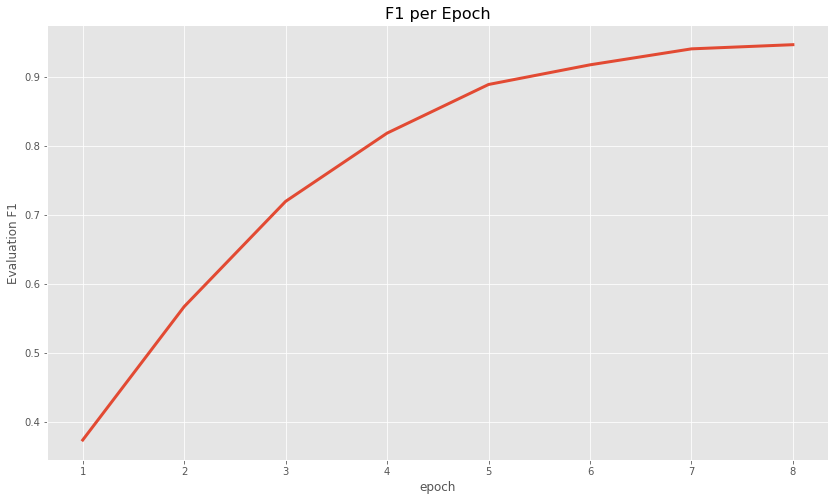

In [30]:
plt.figure(figsize=(14,8))
plt.plot(result['epoch'], result['eval_f1'], linewidth=3)
    
# plt.legend(title="LR")   
plt.xlabel("epoch")
plt.ylabel("Evaluation F1")
plt.title("F1 per Epoch")